## Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
import math
from IPython.core.interactiveshell import InteractiveShell

pd.options.display.max_rows = 999
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Read in data 
data = pd.read_csv('chess_data.csv')
data.shape

(107743, 6)

In [3]:
data.tail()

,player1,player1_elo,player2,player2_elo,winner,game_id
107738,rg370dx,1274,kingsalley,1308,kingsalley,4052426056
107739,tyr124,1307,wasteyouryouth,1213,tyr124,2761996130
107740,MASTER1232L,1131,vishy_inspire_10,1124,vishy_inspire_10,2751584485
107741,cathy_cathy,1315,anon1127,1107,cathy_cathy,145218848
107742,gfendlich,787,shahmatil_tvoyu_mamk,799,shahmatil_tvoyu_mamk,1850793370


## Feature Engineer

In [4]:
# Feature Functions
def is_win(row):
    if row['player1'] == row['winner']:
        return 1
    elif row['player2'] == row['winner']:
        return 0
    else: 
        return 999 # one faulty row in the scrape 

def elo_diff(row):
    return row['player1_elo'] - row['player2_elo']

def is_computer(row):
    return ('computer' in row['player1'].lower()) or ('computer' in row['player2'].lower())

# Apply functions  
data['win'] = data.apply(is_win, axis=1)
data['elo_diff'] = data.apply(elo_diff, axis=1)
data['is_computer'] = data.apply(is_computer, axis=1)

In [5]:
# Drop duplicates and remove drawn games 
print('Before dedup: ' + str(data.shape[0]) + ' rows')
data.drop_duplicates(subset ="game_id", keep = False, inplace = True) 
data = data[data.winner != 'Game']
data = data[data.win != 999] 
data = data[data.is_computer == False]
print('After dedup: ' + str(data.shape[0]) + ' rows')

Before dedup: 107743 rows
After dedup: 102846 rows


In [6]:
data.describe()

,player1_elo,player2_elo,game_id,win,elo_diff
count,102846.000000,102846.000000,1.028460e+05,102846.000000,102846.000000
mean,1267.097777,1266.267653,1.998554e+09,0.519233,0.830125
std,341.293126,340.860320,1.238178e+09,0.499632,120.056757
min,100.000000,118.000000,1.000000e+00,0.000000,-1800.000000
25%,1034.000000,1032.000000,9.259987e+08,0.000000,-46.000000
50%,1265.000000,1264.000000,2.023927e+09,1.000000,1.000000
75%,1494.000000,1493.000000,3.076850e+09,1.000000,47.000000
max,2886.000000,3000.000000,4.107982e+09,1.000000,2216.000000


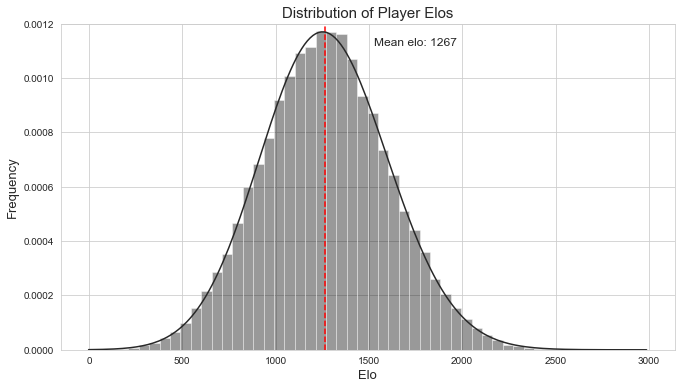

In [22]:
mean_elo = data.player1_elo.mean()

sns.set_style("whitegrid")
plt.figure(figsize=(11, 6))

plt.vlines(x=mean_elo, 
           colors='red',
           ymin=0,
           ymax=.0013,
           linestyles='dashed')

sns.distplot(data['player1_elo'], 
             kde=False, 
             fit=stats.gamma,
             color='black')

plt.text(x=1525, 
         y=.00112, 
         s= ('Mean elo: ' + str(int(mean_elo))), 
         fontsize=12)

plt.xlabel('Elo', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Player Elos', fontsize=15)
plt.ylim(0, .0012)

plt.savefig('player_elo_distribution.png')

plt.show()

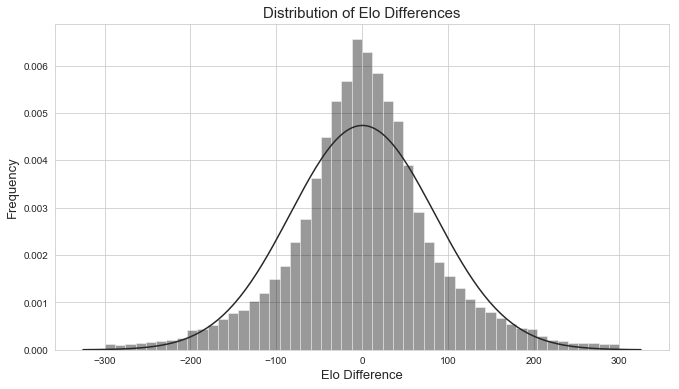

In [26]:
trunc300 = data.loc[data['elo_diff'].between(-300, 300)]

sns.set_style("whitegrid")
plt.figure(figsize=(11, 6))

sns.distplot(trunc300['elo_diff'], 
             kde=False, 
             fit=stats.gamma,
             color='black')

plt.xlabel('Elo Difference', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.title('Distribution of Elo Differences', fontsize=15)

plt.savefig('elo_diff_distribution.png')

plt.show()

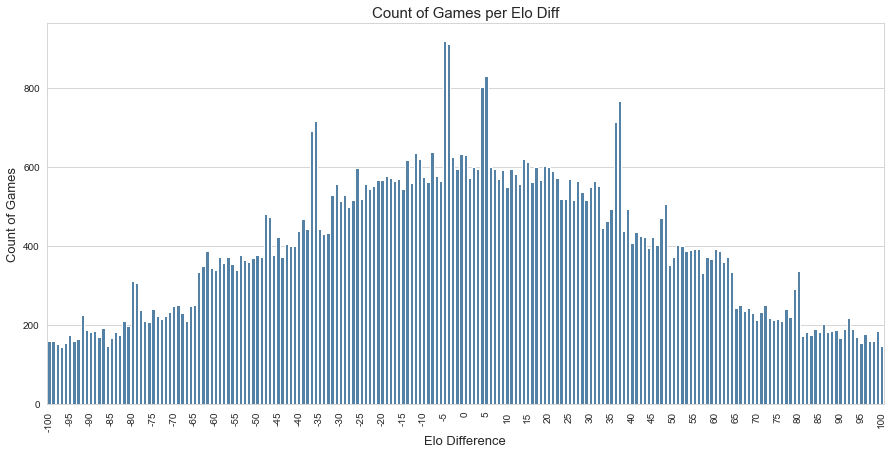

In [42]:
elorange=100

data100 = data.loc[data['elo_diff'].between(-100, 100)]
grouped100 = data100.groupby('elo_diff').count()

sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.barplot(y= 'win', 
            x=grouped100.index,
            data=grouped100,
            color='steelblue'
           )

plt.xlabel('Elo Difference', fontsize=13)
plt.ylabel('Count of Games', fontsize=13)
plt.title('Count of Games per Elo Diff', fontsize=15)
plt.xticks(range(0, elorange*2 + int(elorange/20), int(elorange/20)), 
           range(-elorange, elorange + int(elorange/20), int(elorange/20)), 
           rotation=90)

plt.savefig('count_of_games.png')

plt.show()



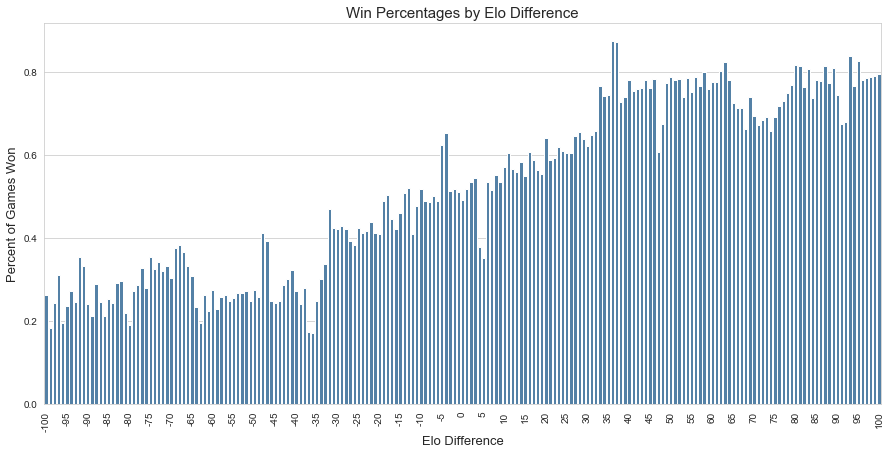

In [47]:
data_trunc = data.loc[data['elo_diff'].between(-100, 100)]
grouped_trunc = data_trunc.groupby('elo_diff').mean()

sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.barplot(y= 'win', 
            x=grouped_trunc.index,
            data=grouped_trunc,
            color='steelblue'
            #palette='coolwarm'
           )

plt.xlabel('Elo Difference', fontsize=13)
plt.ylabel('Percent of Games Won', fontsize=13)
plt.title('Win Percentages by Elo Difference', fontsize=15)
plt.xticks(range(0, elorange*2 + int(elorange/20), int(elorange/20)), 
           range(-elorange, elorange + int(elorange/20), int(elorange/20)), 
           rotation=90)

plt.savefig('win_percentage.png')

plt.show()

## Logistic regression model

In [11]:
def logit_to_prob(logit):
    odds = math.exp(logit)
    prob = odds / (1+odds)
    return(prob)

In [12]:
# Separate independent and dependent variables
X = data['elo_diff']
y = data['win']

# Fit the model
model = sm.Logit(y, X)

# Print the results
result = model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.599047
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.135      
Dependent Variable: win              AIC:              123221.1952
Date:               2019-10-14 20:02 BIC:              123230.7361
No. Observations:   102846           Log-Likelihood:   -61610.    
Df Model:           0                LL-Null:          -71211.    
Df Residuals:       102845           LLR p-value:      nan        
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
--------------------------------------------------------------------
             Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
--------------------------------------------------------------------
elo_diff     0.0110     0.0001   110.1334   0.0000   0.0109   0.0112



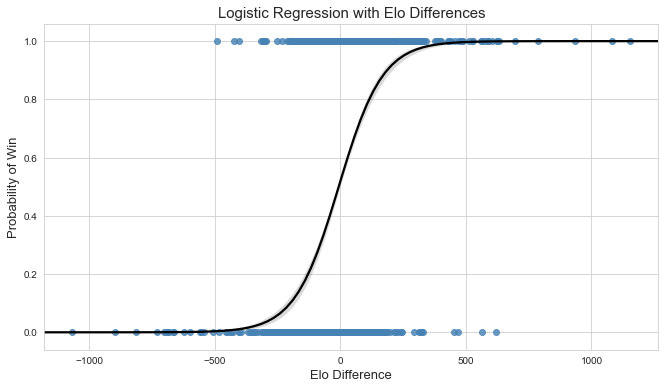

In [48]:
sns.set_style("whitegrid")
plt.figure(figsize=(11, 6))


sns.regplot(x='elo_diff', 
            y='win', 
            data=data.tail(5000), 
            logistic=True,
            color='steelblue',
            line_kws={'color': 'black'})


plt.xlabel('Elo Difference', fontsize=13)
plt.ylabel('Probability of Win', fontsize=13)
plt.title('Logistic Regression with Elo Differences', fontsize=15)

plt.savefig('logistic_regression.png')

plt.show()

In [14]:
# Fit model on training data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_train.reshape(-1, 1)
y_test = y_train.reshape(-1, 1)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))



Accuracy of logistic regression classifier on test set: 0.70


/Users/Eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/Eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/Eric/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Eric/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[22485 12110]
 [ 9759 27638]]


In [16]:
# Recall Percision Accuracy 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67     34595
           1       0.70      0.74      0.72     37397

    accuracy                           0.70     71992
   macro avg       0.70      0.69      0.69     71992
weighted avg       0.70      0.70      0.70     71992



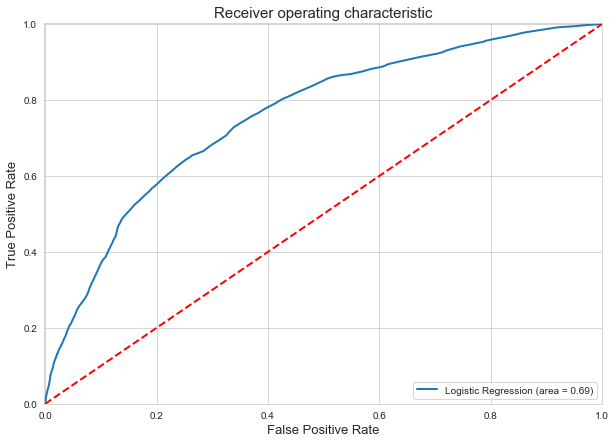

In [17]:
# ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize=(10, 7))

plt.plot(fpr, 
         tpr, 
         label='Logistic Regression (area = %0.2f)' % logit_roc_auc, 
         linewidth=2)

plt.plot([0, 1], [0, 1],
         'r--',
         linewidth=2)

plt.xlim([-0.002, 1.0])
plt.ylim([0.0, 1.002])

plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('Receiver operating characteristic', fontsize=15)
plt.legend(loc="lower right")


#plt.savefig('Log_ROC')
plt.show()

In [18]:
def get_prob(elo_diff):
    a = np.array(elo_diff).reshape(-1,1)
    return logreg.predict_proba(a)[:,1][0]
    
print('5 higher: ' + str(get_prob(5)) + ', 10 higher: ' + str(get_prob(10)))

5 higher: 0.5353305783721336, 10 higher: 0.5491067291840054


In [19]:
pred_values = np.arange(-200, 201).reshape(-1, 1)
predictions = logreg.predict_proba(pred_values)

In [20]:
# How to slice 
predictions[:,1]

array([0.10582608, 0.10688112, 0.10794541, 0.109019  , 0.11010195,
       0.11119432, 0.11229615, 0.11340752, 0.11452846, 0.11565903,
       0.1167993 , 0.1179493 , 0.11910911, 0.12027876, 0.12145831,
       0.12264782, 0.12384734, 0.12505691, 0.1262766 , 0.12750645,
       0.12874651, 0.12999683, 0.13125747, 0.13252847, 0.13380989,
       0.13510176, 0.13640414, 0.13771708, 0.13904062, 0.14037481,
       0.14171969, 0.14307531, 0.14444172, 0.14581896, 0.14720707,
       0.1486061 , 0.15001608, 0.15143706, 0.15286908, 0.15431218,
       0.1557664 , 0.15723177, 0.15870834, 0.16019614, 0.16169521,
       0.16320557, 0.16472728, 0.16626035, 0.16780482, 0.16936073,
       0.1709281 , 0.17250696, 0.17409734, 0.17569928, 0.17731279,
       0.17893789, 0.18057463, 0.18222301, 0.18388307, 0.18555481,
       0.18723827, 0.18893346, 0.19064039, 0.19235909, 0.19408957,
       0.19583184, 0.19758591, 0.19935181, 0.20112953, 0.20291908,
       0.20472048, 0.20653372, 0.20835882, 0.21019577, 0.21204

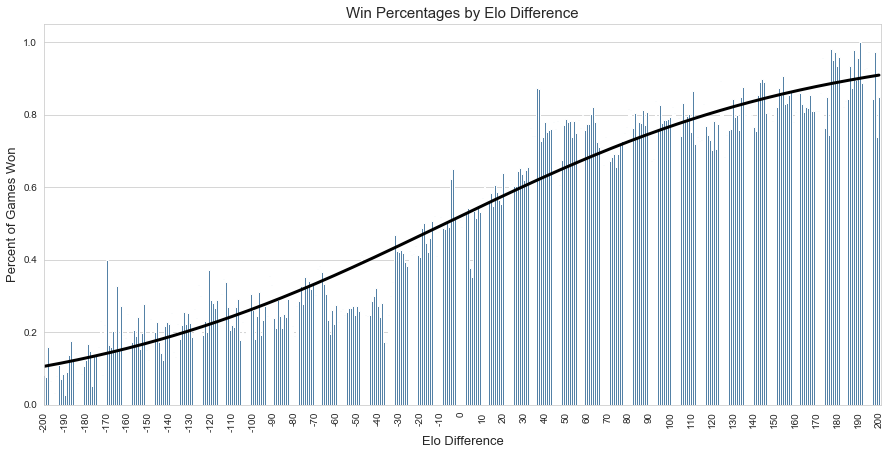

In [56]:
elorange = 200

data_trunc = data.loc[data['elo_diff'].between(-elorange, elorange)]
grouped_trunc = data_trunc.groupby('elo_diff').mean()

sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

sns.barplot(y= 'win', 
            x=grouped_trunc.index,
            data=grouped_trunc,
            color='steelblue'
           )

plt.xlabel('Elo Difference', fontsize=13)
plt.ylabel('Percent of Games Won', fontsize=13)
plt.title('Win Percentages by Elo Difference', fontsize=15)
plt.xticks(range(0, elorange*2 + int(elorange/20), int(elorange/20)), 
           range(-elorange, elorange + int(elorange/20), int(elorange/20)), 
           rotation=90)

plt.xlim(0, 401)

plt.plot(predictions[:,1],
         color='black', 
         linewidth=3
         )

plt.show()

In [57]:
get_prob(1240-2835)

2.2277191316329572e-08